# Loading necessary libraries

In [0]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
root_path = '/content/drive/My Drive/Colab Notebooks'
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/
drive  sample_data


In [0]:
 #%cd drive/My\ Drive
# !mkdir Project
# !mkdir Project/V1
!ls 
#%cd Project/

 Abstract.gdoc	     'Colab Notebooks'	'marrage sabreen and mahreen dedi'
'baramulla college'   home		'my study doccuments'
 Classroom	      IUST		 Project
/content/drive/My Drive/Project


In [0]:
# %cd Project/
!unzip fer2013.zip -d ./V1/

Archive:  fer2013.zip
replace ./V1/fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import pandas as pd 
import cv2
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

Using TensorFlow backend.


True

# Loading and preprocessing images

In [0]:
# !unzip ../content/fer2013.zip
%cd V1

/content/drive/My Drive/Project/V1


In [0]:
#load data set
data = pd.read_csv("./fer2013.csv")

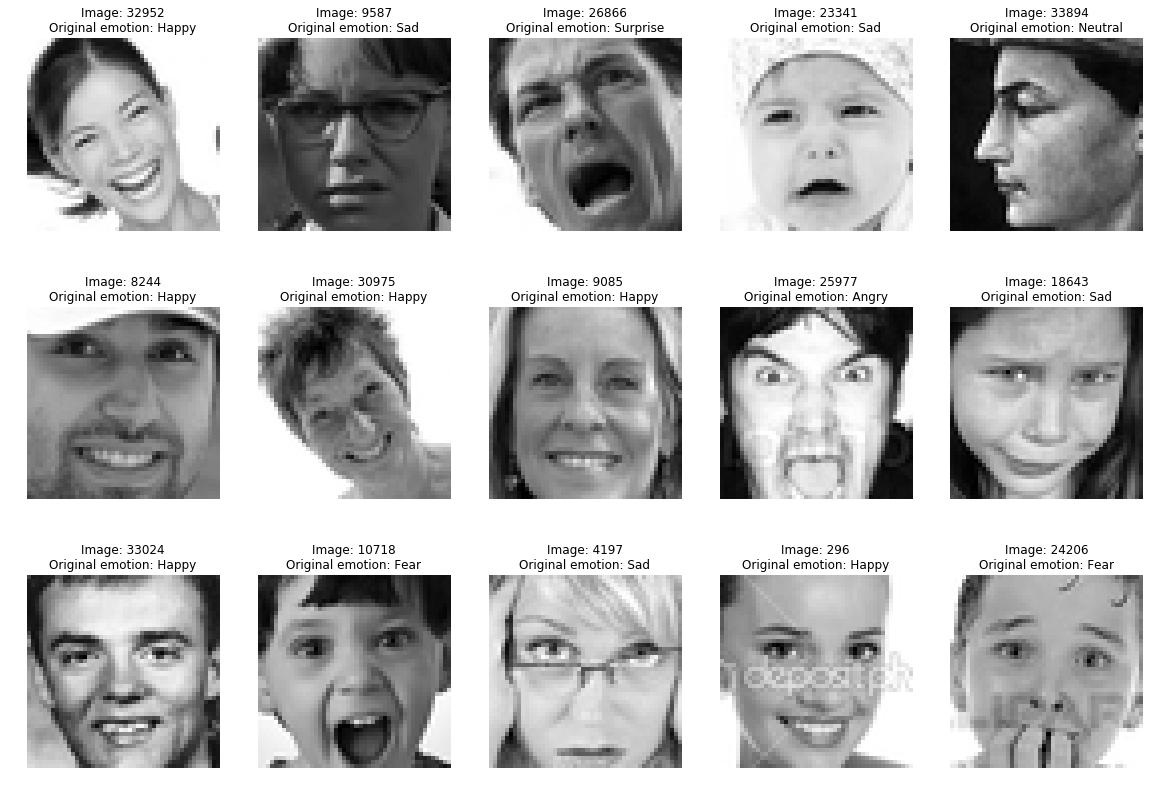

In [0]:


emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
    """ 

    Function displaying 15 randomly chosen images. Arguments:
    
    imgs:  Source of images
    
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names. As a result, emotion name will be displayed above every image.
    
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names. As a result, emotion name will be displayed above image.
    
    random: Defult "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs) otherwise randomly chosen from values passed into "indices" argument without replacement.
    
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution. 
    
    """
    
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 15)
    else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        

show_random(images, emotion_nms_org= data['emotion_name'])


# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

In [0]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

In [0]:
print('Total Data :'+str(len(data)))
print('X train :'+str(len(X_train)))

Total Data :35887
X train :29068


# Building CNN

In [0]:
# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.20))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.20))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.20))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [0]:
model.summary()

# Training CNN using Data Augmentation

In [0]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='Model.{epoch:02d}-{val_acc:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    nb_epoch=5,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[checkpointer,tensorboard]
                             )


pd.DataFrame(history.history).to_csv("history.csv")

# Loading best model and exploring the results

In [0]:
model2 = load_model('../content/Model.99-0.6096.hdf5')

In [0]:
scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

In [0]:
history = pd.read_csv('history.csv', usecols = ['acc','loss','val_acc','val_loss'])

In [0]:
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['acc'])
    plt.plot(data['val_acc'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history)

In [0]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)

u

In [0]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

In [0]:
correct, results_df = predict_classes(model2, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_lok jaanuabel'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

### Correctly predicted images

In [0]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

### Wronly predicted images

In [0]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)

### Confusion matrix

In [0]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

In [0]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], colour = 'Greens')

# supplying an image to our saved model


W0731 07:43:50.427911 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 07:43:50.432182 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0731 07:43:50.483467 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 07:43:50.484774 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0731 07:43:50.486579 14008168661

[[[94 87 57 ... 57 75 96]
  [91 82 55 ... 59 63 89]
  [92 81 46 ... 56 64 71]
  ...
  [78 74 58 ... 62 70 77]
  [77 66 62 ... 45 70 76]
  [74 62 65 ... 35 74 87]]]


W0731 07:43:50.971762 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0731 07:43:51.054991 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0731 07:43:51.067047 140081686615936 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0731 07:43:51.973932 140081686615936 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: Th

ValueError: ignored

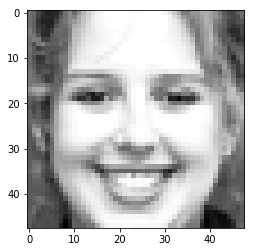

In [0]:
img = Image.open('../content/test.png') # image extension *.png,*.jpg
new_width  = 48
new_height = 48
img = img.resize((new_width, new_height), Image.ANTIALIAS)
plt.imshow(img,cmap="Greys_r")
img.save('new_img.jpg')
new_img = np.expand_dims(img, axis=0)
imag = np.asarray(new_img)
print(imag)
model2 = load_model('../content/Model.49-0.5737.hdf5')
predicted_class = np.argmax(model2.predict(imag))
print(predict_class)
